# Exploratory Data Analysis
Smoothing parameters/ bimodality, & Momentum densities

In [246]:
import logging
import sys
import mmap
import h5py
import torch
from torch.utils.data import Dataset
import numpy as np
import os
import matplotlib as pyplt
import matplotlib.pyplot as plt
import matplotlib.lines as lines
import seaborn as sns
from joblib import Parallel, delayed
import plotly.figure_factory as ff
import plotly.io as pio
pio.renderers.default = 'iframe'

__file__ = "../utils/helpers.py"
SCRIPT_DIR = os.path.dirname(os.path.abspath(__file__))
sys.path.append(os.path.dirname(SCRIPT_DIR))
from utils.helpers import compute_seq_id, get_config, get_logger
from dataset.rich_dataset import *

## 1. Extracting data
 (_Using modified code from RICHPID, Original author: Bob_)
 - File used: A/Run008594(patched)
 - Events: 172353

In [45]:
logger = get_logger()

In [49]:
# Reading in data from /data/bvelghe/capstone2022/A/ using dataloader RICHDataset
dset_path = "../Run008594.EOSlist.CTRL.p.v2.0.4-01_f.v2.0.4-01_patched.h5"
dset = RICHDataset(
    dset_path
)

2022-05-25 18:14:59,199  INFO      data_version: 5f0df761-9a34-4554-9c50-dc0b338dc19a
2022-05-25 18:14:59,199  INFO      data_version: 5f0df761-9a34-4554-9c50-dc0b338dc19a
2022-05-25 18:14:59,199  INFO      data_version: 5f0df761-9a34-4554-9c50-dc0b338dc19a
2022-05-25 18:14:59,203  INFO      description: NA62 RICH PID dataset - MDS Capstone project - Thu 26 May 2022 01:15:15 AM CEST <bob.velghe@triumf.ca>
2022-05-25 18:14:59,203  INFO      description: NA62 RICH PID dataset - MDS Capstone project - Thu 26 May 2022 01:15:15 AM CEST <bob.velghe@triumf.ca>
2022-05-25 18:14:59,203  INFO      description: NA62 RICH PID dataset - MDS Capstone project - Thu 26 May 2022 01:15:15 AM CEST <bob.velghe@triumf.ca>
2022-05-25 18:14:59,206  INFO      entries: 172353
2022-05-25 18:14:59,206  INFO      entries: 172353
2022-05-25 18:14:59,206  INFO      entries: 172353
2022-05-25 18:14:59,208  INFO      muon_offset: 0
2022-05-25 18:14:59,208  INFO      muon_offset: 0
2022-05-25 18:14:59,208  INFO      m

In [67]:
# Fetching offsets and no. of events (entries)
mu_off = dset.offsets["muon"]
pi_off = dset.offsets["pion"]
pos_off = dset.offsets["positron"]
entries = dset.offsets["entries"]
dset.offsets

{'entries': 172353, 'muon': 0, 'pion': 153881, 'positron': 170688}

## 3. EDA Objectives 

We have already done preliminary exploratory data analysis, wherein we observed a lot of noise in the hits data (variable length array). So, our post preliminary EDA, our key goals are as follows:

### 3.1 Filtering the noise in hits data

To achieve this, we explored hit times ~ chod times delta. Note: While we understand that pointnet/ GCNN, may be able to handle this implicitly, but we might need this for further improving metrics. 

From https://github.com/TRIUMF-Capstone2022/RICHPID/blob/main/docs/slides/intro_data_apr8_v0.pdf, 
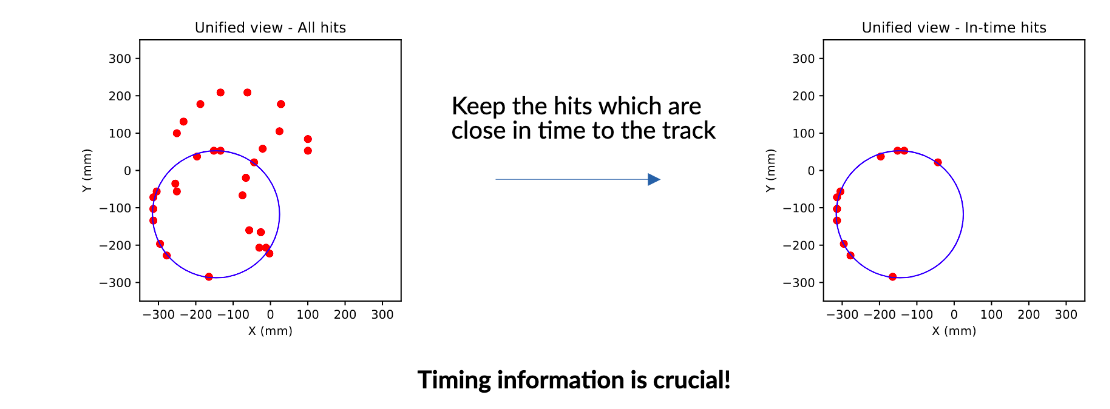

### 3.1.1 A single event (muon)

In [140]:
dset.event_array[dset.event_array['event_id'] == 158056]['chod_time']

array([24.306688], dtype=float32)

In [251]:
dset.event_array[:10]['chod_time']

array([18.484293 ,  3.8471854,  5.7519054,  8.041667 ,  5.636743 ,
        8.19428  , 12.540165 , 21.994987 , 16.112495 , 13.575417 ],
      dtype=float32)

In [143]:
event_no = 1
idx_from = dset.hit_mapping[event_no-1]
idx_to = dset.hit_mapping[event_no]
ht_muon = dset.hit_array[idx_from:idx_to]['hit_time']

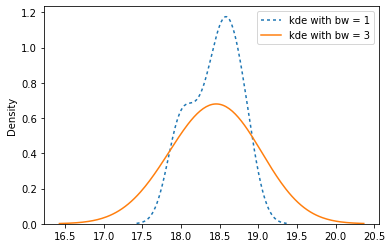

In [145]:
# Resolving the smoothing issue
fig = sns.kdeplot(ht_muon, bw_adjust=1, label = "kde with bw = 1", x = 'delta (ns)', dashes = (2,2))
fig = sns.kdeplot(ht_muon, bw_adjust=3, label = "kde with bw = 3")
plt.legend()
plt.show()

### 3.1.2 Densities of delta (hit time - chod time) for 1000 events

#### n = 1000 Events

In [146]:
# Sample size
n = 1000

In [179]:
event_no = 0
event_0_from = dset.hit_mapping[event_no]
event_0_to = dset.hit_mapping[event_no+1]

20

In [194]:
# define function for getting hits corresponding to ith event
def get_ht(i):
    """Get hit times corresponding to ith event"""
    idx_from = dset.hit_mapping[i]
    idx_to = dset.hit_mapping[i+1]
    hit_times = dset.hit_array['hit_time'][idx_from:idx_to]
    return hit_times

In [214]:
# Defining function for delta
def delta(i):
    return (get_ht(i) - dset.event_array['chod_time'][i]).mean()

In [199]:
# Defining function for randomly sampling indices
def get_idx(n, idx_from, idx_to, seed=123):
    """Returns randomly sampled list of indices"""
    np.random.seed(seed)
    idx_list = np.random.choice(
        range(idx_from, idx_to),
        n, 
        replace = False
    )
    return idx_list

In [200]:
# Muons: 
pi_off - mu_off

153881

In [201]:
# Pions
pos_off - pi_off

16807

In [202]:
# Positrons
entries - 1 - pos_off

1664

In [203]:
# Getting 1000, 10,000 indices (Except pion which has only 1170 events)
# Muons
idx_list_muon_1000 = get_idx(1000, mu_off, pi_off)
idx_list_muon_10_000 = get_idx(10000, mu_off, pi_off)

# Pions
idx_list_pion_1000 = get_idx(1000, pi_off, pos_off)
idx_list_pion_10_000 = get_idx(10000, pi_off, pos_off)

# Positrons
idx_list_positron_1000 = get_idx(1000, pos_off, entries - 1)

In [215]:
# Getting delta for the sampled events - muons
delta_muon_A_1000 = Parallel(n_jobs=-1)(delayed(delta)(int(i)) for i in idx_list_muon_1000)
delta_muon_A_10_000 = Parallel(n_jobs=-1)(delayed(delta)(int(i)) for i in idx_list_muon_10_000)

In [216]:
# Getting delta for the sampled events - pions
delta_pion_A_1000 = Parallel(n_jobs=-1)(delayed(delta)(int(i)) for i in idx_list_pion_1000)
delta_pion_A_10_000 = Parallel(n_jobs=-1)(delayed(delta)(int(i)) for i in idx_list_pion_10_000)

In [217]:
# Getting delta for the sampled events - positrons
delta_positron_A_1000 = Parallel(n_jobs=-1)(delayed(delta)(int(i)) for i in idx_list_positron_1000)

In [247]:
# Add histogram data

# Group data together
hist_data = [
    delta_muon_A_1000, delta_muon_A_10_000,
    delta_pion_A_1000, delta_pion_A_10_000,
    delta_positron_A_1000
]
group_labels = [
    '1k_muon', '10k_muon',
    '1k_pion', '10k_pion',
    '1k_positron'
]

# Create distplot with custom bin_size
fig = ff.create_distplot(hist_data, group_labels, bin_size=0.1, curve_type="normal", )
fig.update_layout(
    title_text=f'Distplots of randomly sampled delta (hit time - chod time) for 1,000 & 10,000 events',
    
)
fig.show()

### 90 % cut-off

In [219]:
# Muons
mean_ = np.mean(delta_muon_A_10_000)
sd_ = np.std(delta_muon_A_10_000)
print((mean_ - 1.645 * sd_, mean_ + 1.645 * sd_))

(-22.889041428565978, 20.715262179374694)


In [220]:
# Pions
mean_ = np.mean(delta_pion_A_10_000)
sd_ = np.std(delta_pion_A_10_000)
print((mean_ - 1.645 * sd_, mean_ + 1.645 * sd_))

(-22.751746187210085, 20.599256763458254)


In [221]:
# Positrons
mean_ = np.mean(delta_positron_A_1000)
sd_ = np.std(delta_positron_A_1000)
print((mean_ - 1.645 * sd_, mean_ + 1.645 * sd_))

(-20.057978485822677, 19.43843737721443)


## 4. Momentum

***Sample size: n = 1000 events***

### 4.1 Muon events

In [226]:
n = 1000

In [235]:
# Defining function for momentum
def momentum(i):
    return dset.event_array['track_momentum'][i]

In [242]:
# Parallelising (currently for 1000 muon events)
p_muon_A = Parallel(n_jobs=-1)(delayed(momentum)(int(i)) for i in idx_list_muon_1000)

### 4.2 Pion Events

In [243]:
p_pion_A = Parallel(n_jobs=-1)(delayed(momentum)(int(i)) for i in idx_list_pion_1000)

### 4.3 Positron events

In [244]:
# Parallelising 
p_pos_A = Parallel(n_jobs=-1)(delayed(momentum)(int(i)) for i in idx_list_positron_1000[:-1])

### 4.4 Overlay of momentum density plots all three particles for n = 1000 each

In [245]:
# Add histogram data
sample_muon = p_muon_A
sample_pion = p_pion_A
sample_positron = p_pos_A

# Group data together
hist_data = [sample_muon, sample_pion, sample_positron]
group_labels = ['muon', 'pion', 'positron']

# Create distplot with custom bin_size
fig = ff.create_distplot(hist_data, group_labels, bin_size = 10,curve_type="normal")
fig.update_layout(
    title_text=f'Distplots of sampled particles (n = {n}) with Normal Distribution',
    
)
fig.show()